[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Dataset Loaded Successfully!
Shape: (2000, 7)
✅ Cleaned dataset saved as cleaned_training_tasks.csv


Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

🔁 Cross-validated TF-IDF SVM Accuracy: 1.0000 ± 0.0000


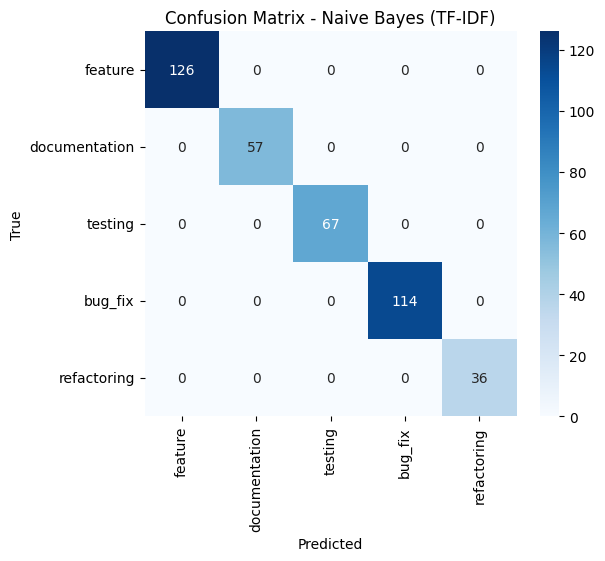

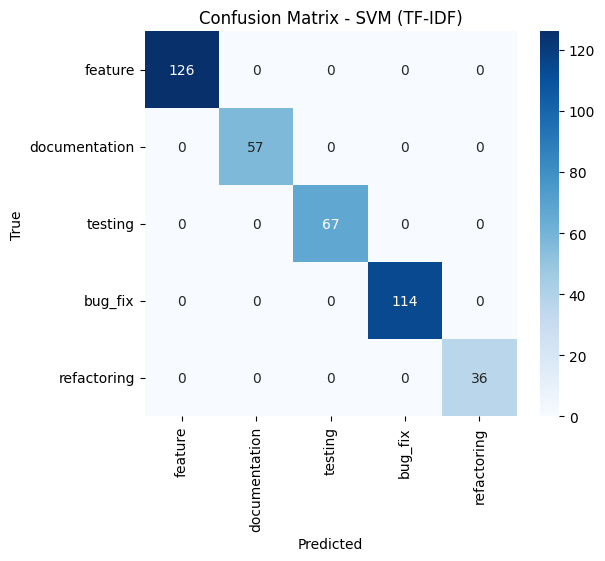

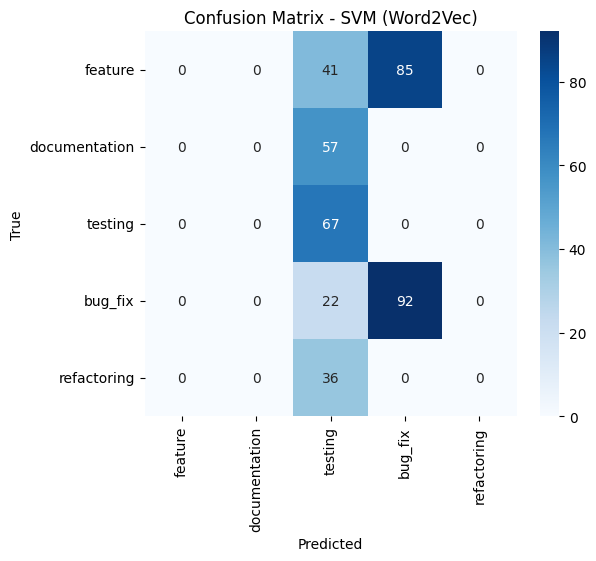

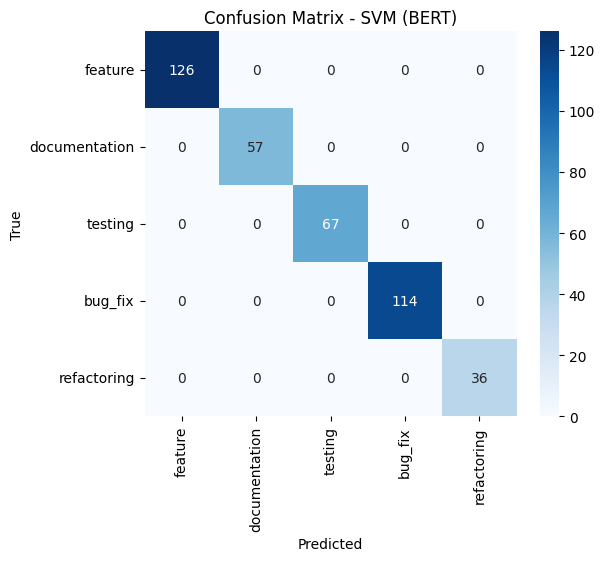

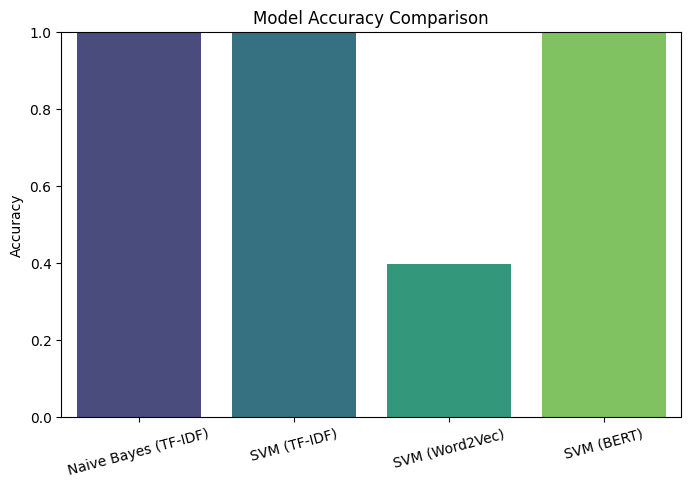


✅ Final Accuracy Summary:
               Model  Accuracy  F1 Score
Naive Bayes (TF-IDF)    1.0000  1.000000
        SVM (TF-IDF)    1.0000  1.000000
      SVM (Word2Vec)    0.3975  0.257603
          SVM (BERT)    1.0000  1.000000


In [ ]:
# ================================================================
# 🧠 AI-Powered Task Management System — Final Project Notebook
# ================================================================

# === 1️⃣ Setup ===
!pip install pandas numpy scikit-learn nltk gensim sentence-transformers matplotlib seaborn joblib

import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

nltk.download('punkt')
nltk.download('stopwords')

# === 2️⃣ Load Dataset ===
df = pd.read_csv(r"E:\Task management system\Data\training_tasks.csv")
print("✅ Dataset Loaded Successfully!")
print(f"Shape: {df.shape}")
df.head()

# === 3️⃣ Basic EDA ===
print("\n--- BASIC INFO ---")
print(df.info())
print("\n--- NULL VALUES ---")
print(df.isnull().sum())
print("\n--- CATEGORY DISTRIBUTION ---")
print(df['category'].value_counts())

# === 4️⃣ Clean + Mask Category Keywords (Leakage-Proof) ===
def mask_category_keywords(text, categories):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Mask categories explicitly
    for cat in categories:
        text = re.sub(r'\b' + re.escape(cat.lower()) + r'\b', ' ', text)
    
    # Mask common task-related and category-like words
    keywords = [
        'test', 'testing', 'bug', 'fix', 'error', 'issue', 'problem', 'debug',
        'feature', 'add', 'implement', 'api', 'function', 'design', 'develop',
        'model', 'deploy', 'backend', 'frontend', 'data', 'train', 'validate',
        'predict', 'report', 'document', 'optimize', 'refactor', 'integration'
    ]
    for k in keywords:
        text = re.sub(r'\b' + k + r's?\b', ' ', text)
    
    text = re.sub(r'\s+', ' ', text).strip()
    return text

categories = df['category'].unique().tolist()
df['clean_text'] = df['title'].astype(str) + " " + df['description'].astype(str)
df['clean_text'] = df['clean_text'].apply(lambda x: mask_category_keywords(x, categories))

# === 5️⃣ NLP Preprocessing ===
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and t not in string.punctuation]
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

df['processed_text'] = df['clean_text'].apply(preprocess_text)

# Save cleaned CSV
os.makedirs("output", exist_ok=True)
df.to_csv("output/cleaned_training_tasks.csv", index=False)
print("✅ Cleaned dataset saved to output/cleaned_training_tasks.csv")

# === 6️⃣ Split Data ===
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['category'], test_size=0.2, random_state=42, stratify=df['category']
)

# === 7️⃣ Feature Extraction ===

## 🔹 TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## 🔹 Word2Vec
def get_word2vec_vectors(texts, size=100):
    tokenized = [nltk.word_tokenize(text) for text in texts]
    w2v_model = Word2Vec(sentences=tokenized, vector_size=size, window=5, min_count=1, workers=4)
    def avg_vector(tokens):
        vectors = [w2v_model.wv[t] for t in tokens if t in w2v_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(size)
    X_vec = np.array([avg_vector(tokens) for tokens in tokenized])
    return X_vec

X_train_w2v = get_word2vec_vectors(X_train)
X_test_w2v = get_word2vec_vectors(X_test)

## 🔹 BERT (Mini model)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_bert = bert_model.encode(X_train.tolist(), show_progress_bar=True)
X_test_bert = bert_model.encode(X_test.tolist(), show_progress_bar=True)

# === 8️⃣ Model Training ===
results = []

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1})
    print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
    print(classification_report(y_true, y_pred))

## Naive Bayes (TF-IDF)
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)
evaluate_model("Naive Bayes (TF-IDF)", y_test, y_pred_nb)

## SVM (TF-IDF)
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)
evaluate_model("SVM (TF-IDF)", y_test, y_pred_svm_tfidf)

## SVM (Word2Vec)
svm_w2v = SVC(kernel='linear')
svm_w2v.fit(X_train_w2v, y_train)
y_pred_svm_w2v = svm_w2v.predict(X_test_w2v)
evaluate_model("SVM (Word2Vec)", y_test, y_pred_svm_w2v)

## SVM (BERT)
svm_bert = SVC(kernel='linear')
svm_bert.fit(X_train_bert, y_train)
y_pred_svm_bert = svm_bert.predict(X_test_bert)
evaluate_model("SVM (BERT)", y_test, y_pred_svm_bert)

# === 9️⃣ Final Summary ===
final_df = pd.DataFrame(results)
print("\n✅ Final Accuracy Summary:")
print(final_df)

# === 🔟 Save Models ===
os.makedirs("models", exist_ok=True)
joblib.dump(nb, "models/naive_bayes_tfidf.pkl")
joblib.dump(svm_tfidf, "models/svm_tfidf.pkl")
joblib.dump(svm_w2v, "models/svm_word2vec.pkl")
joblib.dump(svm_bert, "models/svm_bert.pkl")
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer.pkl")

print("\n✅ Models saved in /models folder")

# === 📊 Confusion Matrix (Example for TF-IDF SVM) ===
cm = confusion_matrix(y_test, y_pred_svm_tfidf)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
plt.title("Confusion Matrix - SVM (TF-IDF)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
